In [1]:
import pandas as pd
import datetime as dt
from binance.client import Client
# install python-binance
# pip install python-binance
import time
import numpy
import requests
import sqlite3
import threading
import matplotlib.pyplot as plt

In [2]:
# API Key (You need to get these from Binance account)
api_key = ''
api_secret = ''

client = Client(api_key=api_key, api_secret=api_secret)

# ticker of product
symbo1_trade = 'BTCUSDT'
#'BTCBUSD'
#'XRPBUSD'

# order quantity (more than 10 USDT)
orderquantity = 35

# bollingerband length and width
length = 20 #lookback period
width = 2 # standard deviation

In [3]:
start_str = '100 day ago UTC'
        # "1 Jan, 2017"
        
interval_data = '1d' 

D = pd.DataFrame(client.get_historical_klines(symbol=symbo1_trade, start_str=start_str, interval=interval_data))
D.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'qav', 'num_trades',
                         'taker_base_vol', 'taker_quote_vol', 'is_best_match']
D['open_date_time'] = [dt.datetime.fromtimestamp(x / 1000) for x in D.open_time]
#print(D)

        
D['symbol'] = symbo1_trade
D = D[['symbol', 'open_date_time', 'open', 'high', 'low', 'close', 'volume', 'num_trades', 'taker_base_vol',
                   'taker_quote_vol']]

In [4]:
btc_df = D

In [5]:
btc_df

,symbol,open_date_time,open,high,low,close,volume,num_trades,taker_base_vol,taker_quote_vol
0,BTCUSDT,2021-04-01 08:00:00,58739.46000000,59490.00000000,57935.45000000,58720.44000000,47415.61722000,1594431,22966.25673600,1351151697.89222195
1,BTCUSDT,2021-04-02 08:00:00,58720.45000000,60200.00000000,58428.57000000,58950.01000000,47382.41878100,1666356,23695.69515400,1406393729.83076923
2,BTCUSDT,2021-04-03 08:00:00,58950.01000000,59791.72000000,56880.00000000,57051.94000000,47409.85211300,1606805,23057.96701700,1353960264.62196262
3,BTCUSDT,2021-04-04 08:00:00,57051.95000000,58492.85000000,56388.00000000,58202.01000000,41314.08197300,1499113,20609.13416100,1187123542.57988340
4,BTCUSDT,2021-04-05 08:00:00,58202.01000000,59272.00000000,56777.77000000,59129.99000000,54258.01579000,2035877,27269.49269000,1586344787.55416885
...,...,...,...,...,...,...,...,...,...,...
95,BTCUSDT,2021-07-05 08:00:00,35288.13000000,35293.78000000,33125.55000000,33690.14000000,64123.87424500,1109367,31489.85537200,1071967415.42531092
96,BTCUSDT,2021-07-06 08:00:00,33690.15000000,35118.88000000,33532.00000000,34220.01000000,58210.59634900,1184687,27801.95449300,951269024.03794967
97,BTCUSDT,2021-07-07 08:00:00,34220.02000000,35059.09000000,33777.77000000,33862.12000000,53807.52167500,1041416,27294.92392700,941984587.97562216
98,BTCUSDT,2021-07-08 08:00:00,33862.11000000,33929.64000000,32077.00000000,32875.71000000,70136.48032000,1257892,35104.65522500,1152928339.82184283


     symbol      open_date_time            open            high  \
19  BTCUSDT 2021-04-20 08:00:00  55633.14000000  57076.24000000   
20  BTCUSDT 2021-04-21 08:00:00  56425.00000000  56757.91000000   
21  BTCUSDT 2021-04-22 08:00:00  53787.62000000  55521.48000000   
22  BTCUSDT 2021-04-23 08:00:00  51690.95000000  52131.85000000   
23  BTCUSDT 2021-04-24 08:00:00  51110.56000000  51166.22000000   
..      ...                 ...             ...             ...   
95  BTCUSDT 2021-07-05 08:00:00  35288.13000000  35293.78000000   
96  BTCUSDT 2021-07-06 08:00:00  33690.15000000  35118.88000000   
97  BTCUSDT 2021-07-07 08:00:00  34220.02000000  35059.09000000   
98  BTCUSDT 2021-07-08 08:00:00  33862.11000000  33929.64000000   
99  BTCUSDT 2021-07-09 08:00:00  32875.71000000  33682.43000000   

               low     close           volume  num_trades  taker_base_vol  \
19  53329.96000000  56425.00   72744.48215100     2148820  35519.58972700   
20  53536.02000000  53787.63   66984.7569

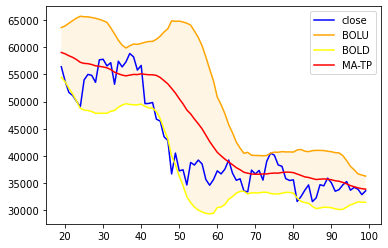

<Figure size 1440x1440 with 0 Axes>

In [6]:
# Boillinger band calculations

btc_df['close'] = btc_df['close'].astype(float)

btc_df['TP'] = btc_df['close'] 
btc_df['std'] = btc_df['TP'].rolling(20).std(ddof=0)
btc_df['MA-TP'] = btc_df['TP'].rolling(20).mean()
btc_df['BOLU'] = btc_df['MA-TP'] + 2*btc_df['std']
btc_df['BOLD'] = btc_df['MA-TP'] - 2*btc_df['std']
#btc_df['open_date_time'] = pd.to_datetime(btc_df['open_date_time'].dt.date)
#btc_df['open_date_time'] = btc_df['open_date_time'].dt.strftime('%Y-%m-%d')

btc_df = btc_df.dropna()
print(btc_df)
# Plotting it all together
ax = btc_df[['close', 'BOLU', 'BOLD','MA-TP']].plot(color=['blue', 'orange', 'yellow','red'])
ax.fill_between(btc_df.index, btc_df['BOLD'], btc_df['BOLU'], facecolor='orange', alpha=0.1)

plt.figure(figsize=(20, 20))
plt.show()

# check band for futures

In [7]:
from binance_f import RequestClient
from binance_f.model import *
from binance_f.constant.test import *
from binance_f.base.printobject import *

request_client = RequestClient(api_key=g_api_key, secret_key=g_secret_key)

result = request_client.get_candlestick_data(symbol="BTCUSDT", interval=CandlestickInterval.DAY1, 
												startTime= None, endTime=None, limit =100)

print("======= Kline/Candlestick Data =======")
PrintMix.print_data(result)

[[1617235200000,"58810.99","59592.22","58002.00","58794.01","196332.114",1617321599999,"11561694922.60452",2133428,"94680.735","5576910250.62599","0"],[1617321600000,"58797.56","60397.85","58490.03","59031.36","189391.958",1617407999999,"11251166314.77901",2130064,"92589.845","5501759219.26745","0"],[1617408000000,"59028.99","59925.00","56900.00","57134.65","198636.171",1617494399999,"11672141257.52950",2247303,"93687.055","5507316845.02153","0"],[1617494400000,"57134.65","58553.00","56517.23","58234.61","152454.122",1617580799999,"8785593781.44870",1778714,"74594.627","4298930356.92053","0"],[1617580800000,"58234.61","59385.00","56808.94","59243.39","174338.646",1617667199999,"10144751892.15272",2011408,"86261.207","5020733701.78477","0"],[1617667200000,"59243.40","59626.18","57500.00","58059.99","165562.029",1617753599999,"9681501016.80336",1949118,"78636.425","4599489382.51682","0"],[1617753600000,"58060.00","58720.00","55536.07","56018.18","265271.707",1617839999999,"15106714000.51

0

In [8]:
D = pd.DataFrame()
D['open_date_time'] = [dt.datetime.fromtimestamp((result[x].closeTime / 1000)-86400) for x in range(len(result))]
D['close'] = [result[x].close for x in range(len(result))]
D['low'] = [result[x].low for x in range(len(result))]
D['high'] = [result[x].high for x in range(len(result))]
D['c_l_h_mean'] = (D['close'].astype(float)+D['low'].astype(float)+D['high'].astype(float))/3

In [9]:
D

,open_date_time,close,low,high,c_l_h_mean
0,2021-04-01 07:59:59.999,58794.01,58002.00,59592.22,58796.076667
1,2021-04-02 07:59:59.999,59031.36,58490.03,60397.85,59306.413333
2,2021-04-03 07:59:59.999,57134.65,56900.00,59925.00,57986.550000
3,2021-04-04 07:59:59.999,58234.61,56517.23,58553.00,57768.280000
4,2021-04-05 07:59:59.999,59243.39,56808.94,59385.00,58479.110000
...,...,...,...,...,...
95,2021-07-05 07:59:59.999,33672.72,33032.00,35281.55,33995.423333
96,2021-07-06 07:59:59.999,34206.01,33500.00,35120.00,34275.336667
97,2021-07-07 07:59:59.999,33845.64,33756.48,35089.56,34230.560000
98,2021-07-08 07:59:59.999,32852.04,32066.00,33910.00,32942.680000


            open_date_time     close       low      high    c_l_h_mean  \
19 2021-04-20 07:59:59.999  56410.56  53330.82  57060.00  55600.460000   
20 2021-04-21 07:59:59.999  53800.00  53610.00  56756.78  54722.260000   
21 2021-04-22 07:59:59.999  51714.61  50534.34  55470.51  52573.153333   
22 2021-04-23 07:59:59.999  51122.62  47546.16  52152.00  50273.593333   
23 2021-04-24 07:59:59.999  50092.40  48690.00  51183.51  49988.636667   
..                     ...       ...       ...       ...           ...   
95 2021-07-05 07:59:59.999  33672.72  33032.00  35281.55  33995.423333   
96 2021-07-06 07:59:59.999  34206.01  33500.00  35120.00  34275.336667   
97 2021-07-07 07:59:59.999  33845.64  33756.48  35089.56  34230.560000   
98 2021-07-08 07:59:59.999  32852.04  32066.00  33910.00  32942.680000   
99 2021-07-09 07:59:59.999  33563.48  32250.00  33700.00  33171.160000   

            std            MA          BOLU          BOLD  
19  2292.668182  59072.620500  63657.956864  54487.

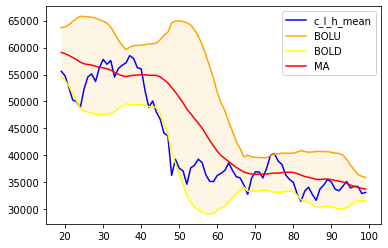

<Figure size 1440x1440 with 0 Axes>

In [10]:
btc_df = D
btc_df['std'] = btc_df['c_l_h_mean'].rolling(20).std(ddof=0)
btc_df['MA'] = btc_df['c_l_h_mean'].rolling(20).mean()
btc_df['BOLU'] = btc_df['MA'] + 2*btc_df['std']
btc_df['BOLD'] = btc_df['MA'] - 2*btc_df['std']
#btc_df['open_date_time'] = pd.to_datetime(btc_df['open_date_time'].dt.date)
#btc_df['open_date_time'] = btc_df['open_date_time'].dt.strftime('%Y-%m-%d')

btc_df = btc_df.dropna()
print(btc_df)
# Plotting it all together
ax = btc_df[['c_l_h_mean', 'BOLU', 'BOLD','MA']].plot(color=['blue', 'orange', 'yellow','red'])
ax.fill_between(btc_df.index, btc_df['BOLD'], btc_df['BOLU'], facecolor='orange', alpha=0.1)

plt.figure(figsize=(20, 20))
plt.show()